In [2]:
import pandas as pd
from transformers import pipeline
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sacrebleu import corpus_bleu
import tqdm
import evaluate
import torch
from transformers import AutoModelForCausalLM
from llama import LlamaForCausalLM
# from llama import MultiTaskLlamaForCausalLM
import lightning as L
from torch.utils.data import DataLoader
import multiprocessing as mp
from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig
from transformers import AutoConfig
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
num_frozen_layers = 8
num_task_layers = 2
max_length = 128
effective_batch_size = 32
batch_size = 32
accumulate_grad_batches = effective_batch_size // batch_size
weight_decay = 0.01
epochs = 3
learning_rate = 5e-5
grad_clip_val = 1.0
max_train_sample_size = 100_000
max_val_sample_size = 10_000
model_name_or_path = "HuggingFaceTB/SmolLM-135M"
use_lora = False
use_qlora = False
is_multi_task = (not use_lora)  and (not use_qlora)
run_name = f"multi-task-{is_multi_task}-frozen-{num_frozen_layers}-task-layers-{num_task_layers}"
print(run_name)

multi-task-True-frozen-8-task-layers-2


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
config = AutoConfig.from_pretrained(model_name_or_path)
config.num_frozen_layers = num_frozen_layers
config.num_task_layers = num_task_layers

if not use_lora and not use_qlora:
    pretrained_model = LlamaForCausalLM.from_pretrained(model_name_or_path)
    
    model = LlamaForCausalLM(config)
    model.load_state_dict(pretrained_model.state_dict(), strict=False)
    for param in model.model.parameters():
        param.requires_grad = False
elif use_lora or use_qlora:
    lora_config = LoraConfig(
        r=16,
        lora_alpha=64,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",   # attention
            "gate_proj", "up_proj", "down_proj"       # MLP
        ],
        lora_dropout=0.1,
        bias="none",
        task_type="CAUSAL_LM"
    )

    if use_qlora:
        # For QLoRA, quantize the model weights to 4-bit
        quantization_config = BitsAndBytesConfig(load_in_4bit=True)
        pretrained_model = LlamaForCausalLM.from_pretrained(model_name_or_path, quantization_config=quantization_config)
        model = LlamaForCausalLM(config)
        model.load_state_dict(pretrained_model.state_dict(), strict=False)
    else:
        pretrained_model = LlamaForCausalLM.from_pretrained(model_name_or_path)
        model = LlamaForCausalLM(config)
        model.load_state_dict(pretrained_model.state_dict(), strict=False)

    model = get_peft_model(model, lora_config)
    print("Model updated with LoRA/QLoRA for parameter-efficient fine-tuning.")



You are using a model of type llama to instantiate a model of type multitask_llama. This is not supported for all configurations of models and can yield errors.


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(pretrained_model)
print(f"Total number of parameters in pretrained model: {total_params:,}")
total_params = count_parameters(model)
print(f"Total number of parameters in multi-task model: {total_params:,}")

Total number of parameters in pretrained model: 134,515,008
Total number of parameters in multi-task model: 134,515,008


In [6]:
template = "English: {english_text} Spanish: {spanish_text} <|END|>"

# exp-data/en-es-train-val.parquet
if not os.path.exists("exp-data/en-es-train-val.parquet"):
    data_df = pd.read_parquet("exp-data/en-es.parquet")
    train_df = data_df[data_df["split"] == "train"].sample(frac=1.0, random_state=42).reset_index(drop=True)
    train_df['length'] = train_df.apply(lambda x: len(tokenizer.encode(template.format(english_text=x['EN'], spanish_text=x['ES']))), axis=1)
    train_df = train_df[train_df['length'] <= max_length].reset_index(drop=True)
    print(f"Number of training samples after length filtering: {len(train_df)}")
    # split train_df 80-20 into train and validation
    split_idx = int(0.8 * len(train_df))
    train_df_split = train_df.iloc[:split_idx].reset_index(drop=True)
    val_df_split = train_df.iloc[split_idx:].reset_index(drop=True)
    train_df = train_df_split
    val_df = val_df_split
    train_df = train_df.sample(min(max_train_sample_size, len(train_df)), random_state=42).reset_index(drop=True)
    val_df = val_df.sample(min(max_val_sample_size, len(val_df)), random_state=42).reset_index(drop=True)
    val_df['split'] = 'val'
    train_df['split'] = 'train'
    print(f"Number of samples: {len(train_df)}")
    print(f"Number of validation samples: {len(val_df)}")
    # to parquet
    train_proc_df = pd.concat([train_df, val_df]).reset_index(drop=True)
    train_proc_df.to_parquet("exp-data/en-es-train-val.parquet")
else:
    train_proc_df = pd.read_parquet("exp-data/en-es-train-val.parquet")
    train_df = train_proc_df[train_proc_df["split"] == "train"].reset_index(drop=True)
    val_df = train_proc_df[train_proc_df["split"] == "val"].reset_index(drop=True)
    print(f"Number of samples: {len(train_df)}")
    print(f"Number of validation samples: {len(val_df)}")

Number of samples: 100000
Number of validation samples: 10000


In [7]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.template = "English: {} Spanish:"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        en_text = self.df.iloc[idx]["EN"]
        es_text = self.df.iloc[idx]["ES"]
        prompt = self.template.format(en_text)
        full_text = template.format(english_text=en_text, spanish_text=es_text)

        # Tokenize prompt and full text
        prompt_ids = self.tokenizer(prompt, truncation=True, max_length=self.max_length, add_special_tokens=False)["input_ids"]
        full_ids = self.tokenizer(full_text, truncation=True, max_length=self.max_length, add_special_tokens=False)["input_ids"]

        # Labels: -100 for prompt, actual tokens for output
        labels = [-100] * len(prompt_ids) + full_ids[len(prompt_ids):]
        input_ids = full_ids

        # Pad if necessary
        pad_len = self.max_length - len(input_ids)
        if pad_len > 0:
            input_ids += [self.tokenizer.pad_token_id] * pad_len
            labels += [-100] * pad_len
        else:
            input_ids = input_ids[:self.max_length]
            labels = labels[:self.max_length]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }

train_dataset = TranslationDataset(train_df, tokenizer, max_length=max_length)
val_dataset = TranslationDataset(val_df, tokenizer, max_length=max_length)

In [8]:
sample_idx = 0
sample = train_dataset[sample_idx]

print("Input token IDs:", sample["input_ids"].tolist())
print("Label token IDs:", sample["labels"].tolist())

Input token IDs: [14901, 42, 339, 3984, 357, 18148, 281, 260, 4052, 30, 5071, 42, 19077, 925, 2756, 4084, 27432, 430, 2618, 425, 13977, 18155, 30, 2067, 108, 16317, 108, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label token IDs: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 19077, 925, 2756, 4084, 27432, 430, 2618, 425, 13977, 18155, 30, 2067, 108, 16317, 108, 46, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

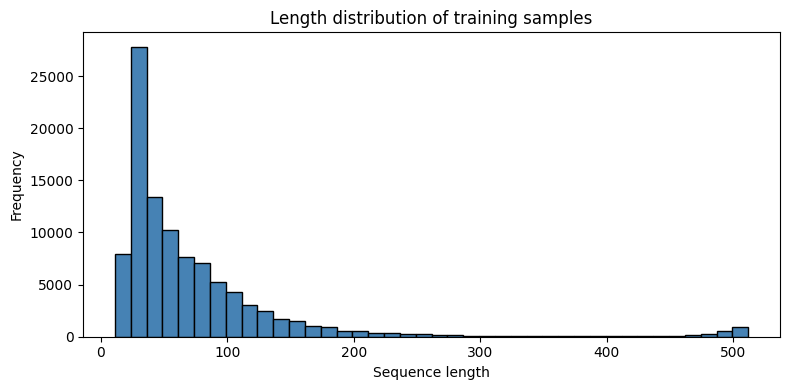

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(train_df["length"], bins=40, color="steelblue", edgecolor="black")
plt.title("Length distribution of training samples")
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# 50 100 200 300 400 max
# 

In [9]:
trimmed_input_ids = [tok_id for tok_id in sample["input_ids"].tolist() if tok_id != tokenizer.pad_token_id]
decoded_inputs = tokenizer.decode(trimmed_input_ids, skip_special_tokens=False)
print("Decoded input text:")
print(decoded_inputs)

trimmed_label_ids = [tok_id for tok_id in sample["labels"].tolist() if tok_id != -100]
decoded_labels = tokenizer.decode(trimmed_label_ids, skip_special_tokens=False)
print("\nDecoded label text:")
print(decoded_labels)

Decoded input text:
English: I heard it thunder in the distance. Spanish: Escuché truenos en la lejanía. <|END|>

Decoded label text:
 Escuché truenos en la lejanía. <|END|>


In [ ]:
sample_idx = 0
sample_row = train_df.iloc[sample_idx]
actual_text = f"{train_dataset.template.format(sample_row['EN'])} {sample_row['ES']} <|END|>"
print("Actual text:", actual_text)

sample = train_dataset[sample_idx]
trimmed_input_ids = [tok_id for tok_id in sample["input_ids"].tolist() if tok_id != tokenizer.pad_token_id]
decoded_text = tokenizer.decode(trimmed_input_ids, skip_special_tokens=False)
print("Decoded text:", decoded_text)

# label
trimmed_label_ids = [tok_id for tok_id in sample["labels"].tolist() if tok_id != -100]
decoded_label_text = tokenizer.decode(trimmed_label_ids, skip_special_tokens=False)
print("Decoded label text:", decoded_label_text)

print("Match:", actual_text.strip() == decoded_text.strip())

Actual text: English: Women are not even allowed to take part in the distribution of bread under the UN world food programme. Spanish: Las mujeres no pueden participar ni siquiera en la distribución de pan del Programa de Alimentación Mundial de la ONU. <|END|>
Decoded text: English: Women are not even allowed to take part in the distribution of bread under the UN world food programme. Spanish: Las mujeres no pueden participar ni siquiera en la distribución de pan del Programa de Alimentación Mundial de la ONU. <|END|>
Match: True


In [ ]:
# Inference example using the model and tokenizer
en_sentence = train_df['EN'][0]
prompt = f"English: {en_sentence} Spanish:"
input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length)["input_ids"]

# Move input_ids to the same device as the model if needed
device = next(model.parameters()).device
input_ids = input_ids.to(device)

# Generate output
with torch.no_grad():
    output_ids = model.generate(input_ids, max_new_tokens=max_length, pad_token_id=tokenizer.pad_token_id)

# Decode the generated Spanish translation
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prompt:", prompt)
print("Generated:", generated_text)

In [ ]:
num_workers = mp.cpu_count() - 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=num_workers)

In [ ]:
class LitTranslationModel(L.LightningModule):
    def __init__(self, model, tokenizer, lr=2e-5):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr

    def forward(self, input_ids, labels=None):
        return self.model(input_ids=input_ids, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.model(input_ids=batch["input_ids"], labels=batch["labels"])
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self.model(input_ids=batch["input_ids"], labels=batch["labels"])
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))
        return [optimizer], [scheduler]


early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=2,
    verbose=True,
    mode="min"
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=f"exp-data/runs/{run_name}/checkpoints",
    filename="best-{epoch:02d}-{val_loss:.4f}"
)

wandb_logger = WandbLogger(name="bitzbrain", project="en-es", log_model="all")

lit_model = LitTranslationModel(model, tokenizer, lr=learning_rate)

trainer = L.Trainer(
        max_epochs=epochs, 
        accelerator="auto", 
        devices="auto",
        accumulate_grad_batches=accumulate_grad_batches,
        gradient_clip_algorithm="norm",
        gradient_clip_val=grad_clip_val,
        callbacks=[early_stop_callback, checkpoint_callback],
        logger=wandb_logger,
    )

In [ ]:
trainer.fit(lit_model, train_loader, val_loader)